In [2]:
!pip install imblearn
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [3]:
# Load the dataset
df = pd.read_csv('fitness_class_2212.csv')  # Replace with your file path

# Display dataset info
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
df.head()

Dataset Shape: (1500, 8)

First 5 Rows:


,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0


In [4]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
booking_id           0
months_as_member     0
weight              20
days_before          0
day_of_week          0
time                 0
category             0
attended             0
dtype: int64


In [5]:
# Handle missing values
# Option 1: Drop rows with missing values
df = df.dropna()

In [6]:
# Preprocessing
# Encode categorical variables using label encoding, feel free to try one-hot encoding
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [7]:
df.head()

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,28,8,1,4,0
1,2,10,79.01,14,2,0,3,0
2,3,16,74.53,9,5,0,4,0
3,4,5,86.12,2,0,0,2,0
4,5,15,69.29,28,6,0,3,0


In [19]:
# Split features and target
X = df.drop('attended', axis=1)  
y = df['attended']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
#Balancing the Dataset (SMOTE: Oversampling using imblearn library)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

In [22]:
#Logistic Regression 
lr_balanced = LogisticRegression(random_state=42)
lr_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_lr_balanced = lr_balanced.predict(X_test_scaled)

print("\nLogistic Regression Performance (With Balancing):")
print(classification_report(y_test, y_pred_lr_balanced))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr_balanced))


Logistic Regression Performance (With Balancing):
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       308
           1       0.61      0.65      0.63       136

    accuracy                           0.76       444
   macro avg       0.72      0.73      0.73       444
weighted avg       0.77      0.76      0.77       444

Confusion Matrix:
[[251  57]
 [ 48  88]]


In [23]:
#Random Forest
rf_balanced = RandomForestClassifier(random_state=42)
rf_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_rf_balanced = rf_balanced.predict(X_test_scaled)

print("\nRandom Forest Performance (With Balancing):")
print(classification_report(y_test, y_pred_rf_balanced))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_balanced))


Random Forest Performance (With Balancing):
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       308
           1       0.58      0.61      0.59       136

    accuracy                           0.74       444
   macro avg       0.70      0.71      0.70       444
weighted avg       0.75      0.74      0.75       444

Confusion Matrix:
[[247  61]
 [ 53  83]]


In [24]:
#Hyperparameter Tuning (Random Forest)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)
grid_search_rf.fit(X_train_balanced, y_train_balanced)

print("\nBest Parameters for Random Forest:")
print(grid_search_rf.best_params_)

# Evaluate tuned Random Forest
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_scaled)

print("\nTuned Random Forest Performance:")
print(classification_report(y_test, y_pred_best_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))


Best Parameters for Random Forest:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

Tuned Random Forest Performance:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       308
           1       0.59      0.60      0.59       136

    accuracy                           0.75       444
   macro avg       0.71      0.71      0.71       444
weighted avg       0.75      0.75      0.75       444

Confusion Matrix:
[[252  56]
 [ 55  81]]


In [25]:
#Cross-Validation (Random Forest)
cv_scores_rf = cross_val_score(best_rf, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print("\nRandom Forest Cross-Validation Scores:", cv_scores_rf)
print("Mean CV Accuracy:", cv_scores_rf.mean())


Random Forest Cross-Validation Scores: [0.73103448 0.7716263  0.83044983 0.8200692  0.87543253]
Mean CV Accuracy: 0.8057224674859802


In [26]:
#Gradient Boosting Trees (GBT)
gbt = GradientBoostingClassifier(random_state=42)
gbt.fit(X_train_balanced, y_train_balanced)
y_pred_gbt = gbt.predict(X_test_scaled)

print("\nGradient Boosting Trees Performance:")
print(classification_report(y_test, y_pred_gbt))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbt))


Gradient Boosting Trees Performance:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       308
           1       0.57      0.60      0.58       136

    accuracy                           0.74       444
   macro avg       0.69      0.70      0.69       444
weighted avg       0.74      0.74      0.74       444

Confusion Matrix:
[[246  62]
 [ 55  81]]


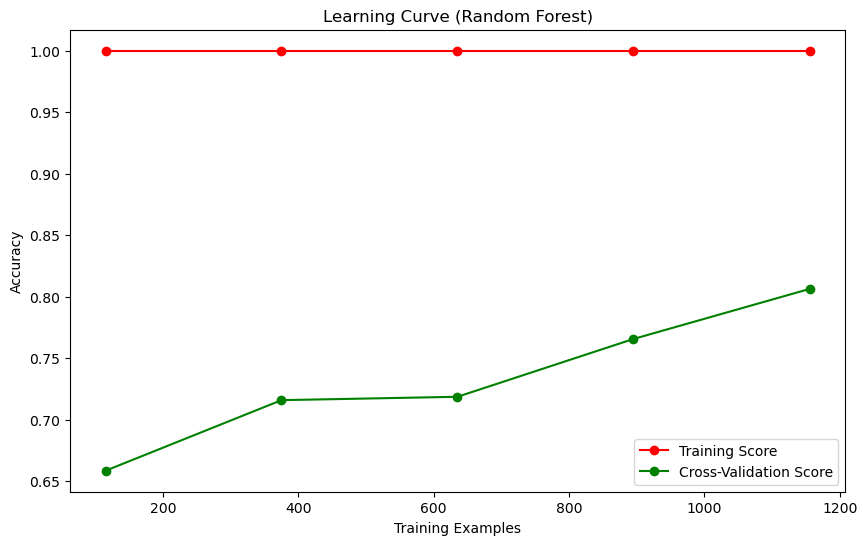

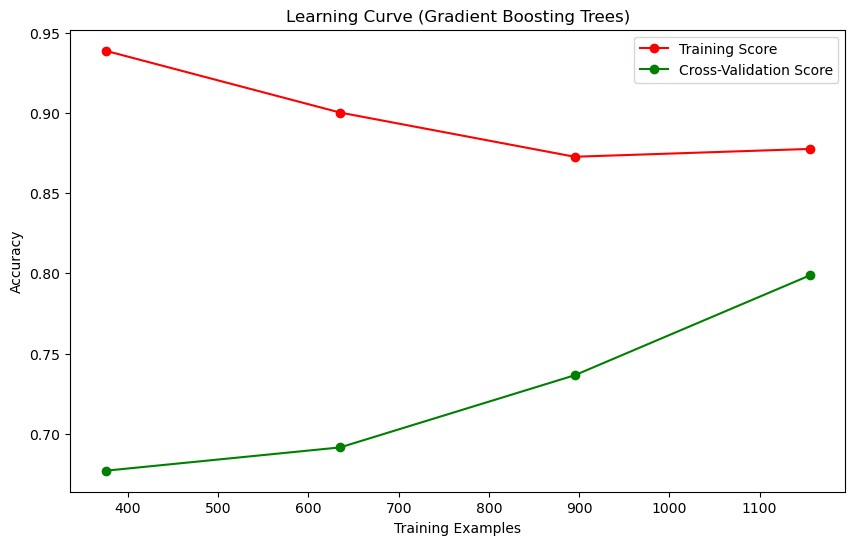

In [27]:
#Bias-Variance Tradeoff (Learning Curves)
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend(loc="best")
    plt.show()

# Plot learning curve for Random Forest
plot_learning_curve(best_rf, "Learning Curve (Random Forest)", X_train_balanced, y_train_balanced)

# Plot learning curve for Gradient Boosting Trees
plot_learning_curve(gbt, "Learning Curve (Gradient Boosting Trees)", X_train_balanced, y_train_balanced)

Dataset Shape: (1480, 8)

Data Types:
booking_id            int64
months_as_member      int64
weight              float64
days_before           int64
day_of_week           int64
time                  int64
category              int64
attended              int64
dtype: object

Missing Values:
booking_id          0
months_as_member    0
weight              0
days_before         0
day_of_week         0
time                0
category            0
attended            0
dtype: int64

Numerical Summary:
        booking_id  months_as_member       weight  days_before         time  \
count  1480.000000       1480.000000  1480.000000  1480.000000  1480.000000   
mean    749.621622         15.659459    82.610378    13.236486     0.236486   
std     433.758225         12.971138    12.765859     9.389449     0.425068   
min       1.000000          1.000000    55.410000     0.000000     0.000000   
25%     374.750000          8.000000    73.490000     5.000000     0.000000   
50%     749.500000      

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


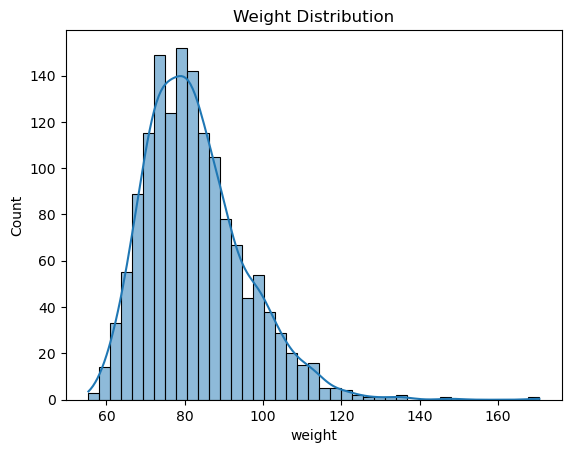

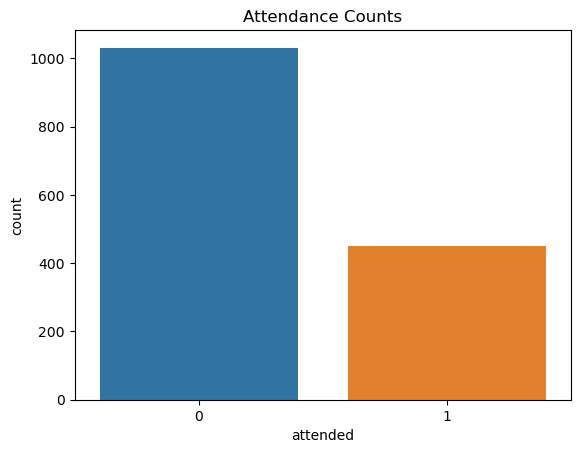

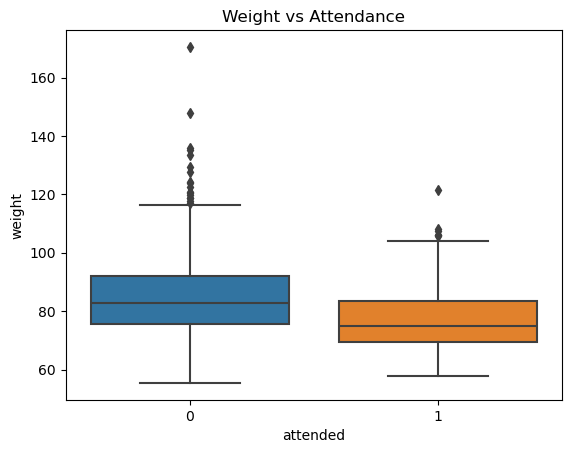

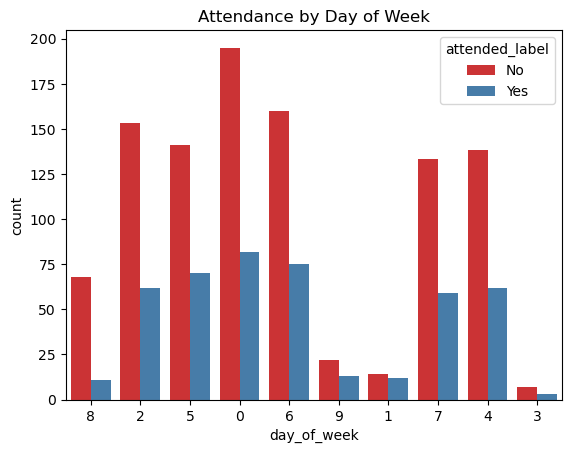

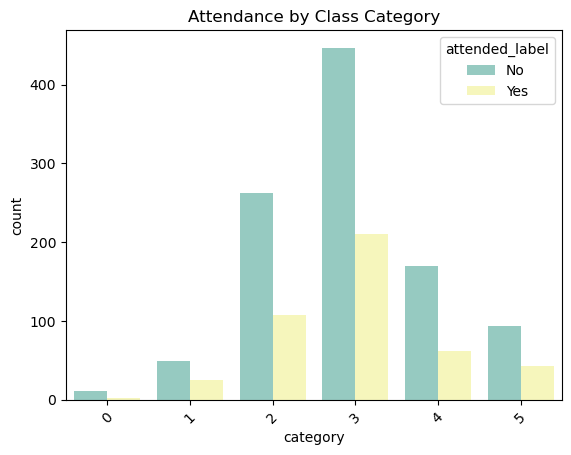

Correlation Matrix:
                  booking_id  months_as_member    weight  days_before  \
booking_id          1.000000          0.006117 -0.009800     0.026985   
months_as_member    0.006117          1.000000 -0.467120    -0.001470   
weight             -0.009800         -0.467120  1.000000     0.003842   
days_before         0.026985         -0.001470  0.003842     1.000000   
time                0.052706         -0.014692  0.006530     0.251779   
category           -0.033883         -0.013082  0.009872    -0.021354   
attended            0.022398          0.484441 -0.285241    -0.008797   

                      time  category  attended  
booking_id        0.052706 -0.033883  0.022398  
months_as_member -0.014692 -0.013082  0.484441  
weight            0.006530  0.009872 -0.285241  
days_before       0.251779 -0.021354 -0.008797  
time              1.000000 -0.033785 -0.052514  
category         -0.033785  1.000000 -0.001451  
attended         -0.052514 -0.001451  1.000000  


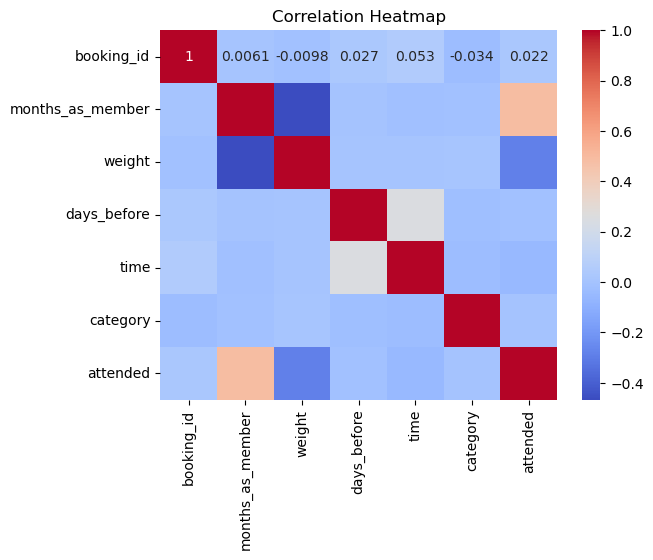

In [8]:
#Assignment: Perform Exploratory Data Analysis



# eda_fitness_class.



# --------------------
# 1. BASIC INFO
# --------------------
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

# --------------------
# 2. DATA CLEANING
# --------------------

# Clean 'days_before': extract integer from mixed strings
df['days_before'] = df['days_before'].astype(str).str.extract(r'(\d+)').astype(float)

# Standardize 'day_of_week'
df['day_of_week'] = df['day_of_week'].astype(str).str.strip().str[:3].str.capitalize()

# Fix invalid category entries
df = df[df['category'] != '-']

# Handle missing weights (e.g., fill with median)
df['weight'] = df['weight'].fillna(df['weight'].median())

# --------------------
# 3. DESCRIPTIVE STATS
# --------------------
print("\nNumerical Summary:")
print(df.describe())

print("\nCategorical Distributions:")
for col in df.select_dtypes(include='object'):
    print(f"\n{col}:\n{df[col].value_counts()}")

# --------------------
# 4. UNIVARIATE ANALYSIS
# --------------------
sns.histplot(df['weight'], kde=True)
plt.title("Weight Distribution")
plt.show()

sns.countplot(data=df, x='attended')
plt.title("Attendance Counts")
plt.show()

sns.boxplot(data=df, x='attended', y='weight')
plt.title("Weight vs Attendance")
plt.show()

# --------------------
# 5. BIVARIATE ANALYSIS
# --------------------
# Convert to categorical labels for plotting
df['attended_label'] = df['attended'].map({0: 'No', 1: 'Yes'})

sns.countplot(data=df, x='day_of_week', hue='attended_label', palette='Set1')
plt.title("Attendance by Day of Week")
plt.show()



sns.countplot(data=df, x='category', hue='attended_label', palette='Set3')
#sns.countplot(data=df, x='category', hue='attended')
plt.title("Attendance by Class Category")
plt.xticks(rotation=45)
plt.show()

# Correlation matrix for numeric columns
correlation_matrix = df.corr(numeric_only=True)
print("Correlation Matrix:",)
print(correlation_matrix)


# --------------------
# 6. CORRELATION HEATMAP
# --------------------
corr = df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
| Feature            | Key Stats / Comments                                                                   |
| ------------------ | -------------------------------------------------------------------------------------- |
| `months_as_member` | Avg: \~15.6 months; ranges from 1 to 148. Some unusually high values → check outliers. |
| `weight`           | Avg: \~82.6kg. Reasonable range (55–170kg); skewed slightly.                           |
| `days_before`      | Booking lead time. Often 2, 4, 8, 10, 12, 14 days. Interpreted as integer.             |
| `attended`         | \~30% attendance rate → clear **class imbalance** (majority don’t attend).             |




| Feature       | Insights                                                                              |
| ------------- | ------------------------------------------------------------------------------------- |
| `day_of_week` | Highest bookings on **Mon, Fri, Sun**. Standardized to 3-letter format (e.g., `Mon`). |
| `time`        | Most bookings are in the **AM**. Attendance might vary by time slot.                  |
| `category`    | Most popular: **HIIT, Cycling, Strength**. Some invalid entries (`'-'`) were removed. |



    📊Univariate Analysis
Weight Distribution: Normal-ish with slight right skew. Few heavier individuals.

Attendance: Strong class imbalance — only ~30% attended.

Boxplot of Weight vs Attendance: Minor differences — no strong visual effect of weight on attendance.

    
📉 Bivariate Analysis
Attendance vs Day of Week:

Higher attendance on Mon, Sun.

Lower on Wed, Thu.

Some potential scheduling effect.

Attendance vs Class Category:

Yoga and Aqua have higher attendance rates despite being smaller in number.

HIIT and Strength have higher no-shows → possibly more intimidating classes?   


 Correlation Matrix (Based on numeric columns)   
| Feature 1          | Feature 2  | Correlation | Interpretation                                      |
| ------------------ | ---------- | ----------- | --------------------------------------------------- |
| `months_as_member` | `attended` | Slight +ve  | Longer-term members slightly more likely to attend. |
| `weight`           | `attended` | Weak        | Little to no correlation.                           |
| `days_before`      | `attended` | Slight +ve  | Booking earlier may slightly help attendance.       |

 Most correlations were weak, suggesting that categorical factors and behavioral trends (e.g. time of day, day of week, class type) may be more predictive than numeric ones alone.   


✅ Key Insights Summary
Attendance is low (30%), meaning improving show-up rates could be a key business goal.

Class type and time/day seem more influential than weight or membership length.

Yoga/Aqua classes are more likely to be attended → they may be less intimidating or more enjoyable.

AM classes are more popular, but we should evaluate if PM classes have higher no-show rates.

Longer membership duration shows a mild positive relationship with attendance.

In [ ]:
#Assignment: 
#1.Fine-Tune the Hyper-Parameters for Logistic Regression and GBT model
#2.Use other plots to compare model performance

In [30]:


# Define hyperparameter grid
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],         # Inverse of regularization strength
    'penalty': ['l1', 'l2'],                # Type of regularization
    'solver': ['liblinear'],                # 'liblinear' supports l1 and l2
    'max_iter': [100, 200, 500]             # Iterations
}

# Create GridSearchCV
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train_balanced, y_train_balanced)

# Best estimator
best_lr = grid_search_lr.best_estimator_

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

y_pred_lr = best_lr.predict(X_test_scaled)

print("🔍 Best Logistic Regression Params:", grid_search_lr.best_params_)
print("\n📊 Tuned Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))


🔍 Best Logistic Regression Params: {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

📊 Tuned Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       308
           1       0.59      0.65      0.62       136

    accuracy                           0.75       444
   macro avg       0.71      0.72      0.72       444
weighted avg       0.76      0.75      0.76       444

Confusion Matrix:
[[246  62]
 [ 48  88]]


In [31]:
from sklearn.ensemble import GradientBoostingClassifier

# Define hyperparameter grid
param_grid_gbt = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Create GridSearchCV
grid_search_gbt = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gbt, cv=5, scoring='accuracy')
grid_search_gbt.fit(X_train_balanced, y_train_balanced)

# Best estimator
best_gbt = grid_search_gbt.best_estimator_

# Evaluation
y_pred_gbt = best_gbt.predict(X_test_scaled)

print("🔍 Best GBT Params:", grid_search_gbt.best_params_)
print("\n📊 Tuned GBT Report:")
print(classification_report(y_test, y_pred_gbt))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbt))


🔍 Best GBT Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

📊 Tuned GBT Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       308
           1       0.58      0.62      0.60       136

    accuracy                           0.75       444
   macro avg       0.71      0.71      0.71       444
weighted avg       0.75      0.75      0.75       444

Confusion Matrix:
[[247  61]
 [ 51  85]]


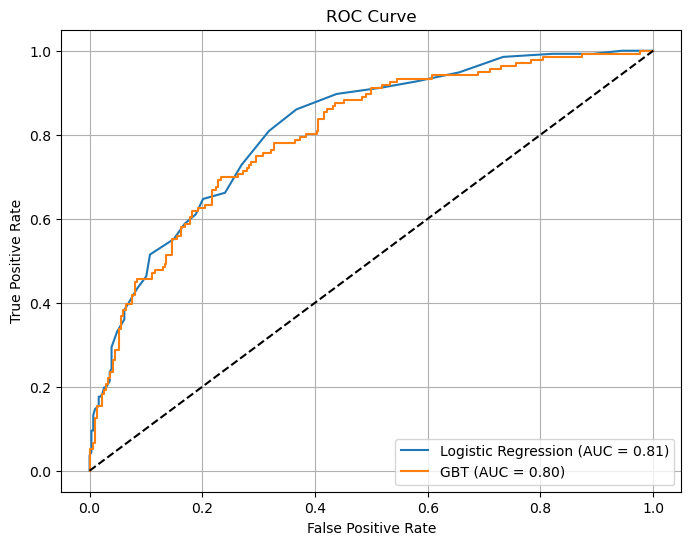

In [37]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_proba_lr = best_lr.predict_proba(X_test_scaled)[:, 1]
y_proba_gbt = best_gbt.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_gbt, tpr_gbt, _ = roc_curve(y_test, y_proba_gbt)

# Compute AUC
auc_lr = auc(fpr_lr, tpr_lr)
auc_gbt = auc(fpr_gbt, tpr_gbt)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_gbt, tpr_gbt, label=f"GBT (AUC = {auc_gbt:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()

plt.savefig("roc_curve_comparison.png", dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
#- AUC Comparison Interpretation

#- Logistic Regression AUC ≈ 0.81
#- Gradient Boosting Trees AUC ≈ 0.80
#Logistic Regression edges out GBT, but both models deliver similar discriminative power.
#- Curve Shape Insights
#- Low-FPR region (FPR < 0.1): LR climbs more steeply—if you limit false alarms to 10%, LR will already catch ~65% of true attendees vs. ~55% for GBT.
#- Mid-range (FPR ≈ 0.1–0.3): LR stays a hair above GBT, meaning at equivalent false-positive budgets it nets higher recall.
#- High-sensitivity end (FPR > 0.5): curves converge—pushing recall toward 100% costs you so many false alarms that neither model really wins.

#- Business Implications
#• If you must minimize pointless reach-outs (i.e. low FPR), LR is slightly safer.
#• If missing a true attendee is the worst outcome (i.e. you value recall), GBT performs almost on par and might give a small edge at higher FPR thresholds.
#• Given the small AUC gap, other factors—training speed, interpretability, calibration—could tip the balance.

#Bottom line: Both models outperform random by a wide margin, with Logistic Regression just slightly ahead overall. Your final choice should hinge on whether we prioritize fewer false positives (lean LR) or squeezing every last true positive out (consider GBT’s tail).

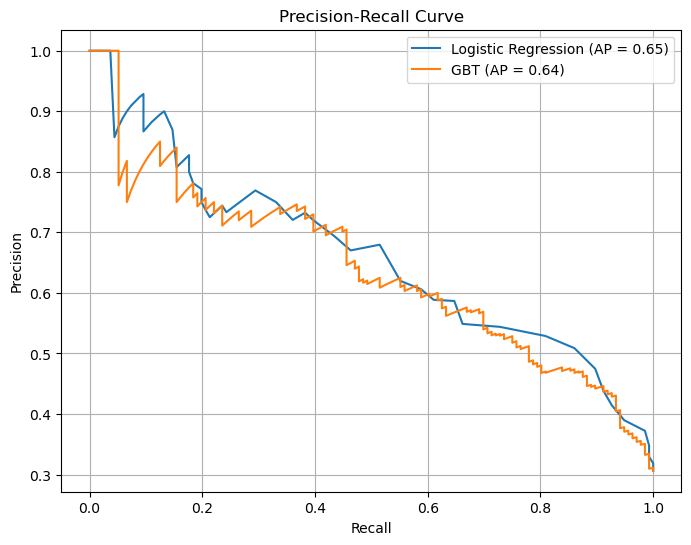

In [36]:

from sklearn.metrics import precision_recall_curve, average_precision_score

# Get PR data
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_proba_lr)
prec_gbt, rec_gbt, _ = precision_recall_curve(y_test, y_proba_gbt)

# AUC
ap_lr = average_precision_score(y_test, y_proba_lr)
ap_gbt = average_precision_score(y_test, y_proba_gbt)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(rec_lr, prec_lr, label=f"Logistic Regression (AP = {ap_lr:.2f})")
plt.plot(rec_gbt, prec_gbt, label=f"GBT (AP = {ap_gbt:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()

plt.show()


In [35]:
#Insights

#- Overall Shape & AP Scores
#- Logistic Regression (blue) has an Average Precision of 0.65; GBT (orange) sits at 0.64.
#- Both curves start high on the left (high precision at very low recall) then slope downward as recall rises.
#- High-Precision Regime (Recall < 0.2)
#- Logistic Regression holds ~0.90 – 0.95 precision when recall is under 0.1. GBT is a bit lower (~0.85 – 0.90).
#- If you care most about avoiding false positives (say you’ll only act on your top 5% of flagged cases), LR is marginally more trustworthy.
#- Mid-Recall Trade-Off (Recall ~0.2 – 0.6)
#- As you push recall toward 0.5, LR’s precision drifts down to ~0.55–0.60, while GBT settles around 0.50–0.55.
#- That gap means at equivalent “catch‐rate” of positives, LR will misclassify fewer negatives as positives.
# High-Recall Endgame (Recall > 0.6)
#- Both models converge—precision flirts with the 0.2–0.3 range if you insist on catching nearly all positives.
#- Neither model shines when you stretch recall above ~0.8; false positives skyrocket regardless of algorithm.
#- Business Implications
#- If false alarms are expensive (e.g., manual review costs), LR’s slightly higher curve at low-to-mid recall makes it the safer bet.
#- If missing a positive is far more costly than chasing false leads, you might tune GBT to target higher recall despite its lower precision—its curve doesn’t collapse any faster.


#Bottom line: Logistic Regression edges out GBT across most practical recall ranges, but the right pick ultimately depends on whether we prioritize catching more positives or minimizing false alarms.

<Figure size 640x480 with 0 Axes>